# Feature extraction 

In [1]:
import librosa
import numpy as np
import math
from pysndfx import AudioEffectsChain
import python_speech_features
import matplotlib.pyplot as plt 
import librosa.display
import pandas as pd
import IPython.display as ipd
import warnings
import sklearn
from sklearn.preprocessing import MinMaxScaler

#Ignore unwanted warnings.
warnings.filterwarnings('ignore')

#Gender of the each speaker
gender = {'19': 'F', '26': 'M', '27': 'M', '32':'F', '39': 'F', '40': 'F',
          '60': 'M', '78': 'M', '83': 'F', '87':'F', '89':'F','103':'F','118':'M',
          '125':'F','150':'F','163':'M','196':'M','198':'F','200':'F'}

def read_file(loc):
    """
    This function read the audio files and the outputs are sr=22050:22kHz, the sampling frequency, and x is the signal
    """
    files = librosa.util.find_files(loc, ext=['wav']) 
    files = np.asarray(files)
    return files

def ambient_noise_reduction(y, sr):
    """
    This function is based on the method presented on Ambient Noise Reduction in the Master thesis reference.
    The goal is to reduce the noise which exists in the background of the environment.
    First finds the centroids of the frames, then their minimum and maximum to use them
    as the upper and lower thresholds respectively.
    At the end, it decreases the gains of the noisy part of the audio.
    """
    sc = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=int(0.025 * sr), hop_length=int(0.010 * sr))
    #This code finds the centroids of each frame with the length of 25ms and hop length of 10ms
    upper_threshold = np.max(sc)
    lower_threshold = np.min(sc)
    noise_reduced = AudioEffectsChain().lowshelf(gain=-30.0, frequency=lower_threshold).highshelf(gain=-30.0, frequency=upper_threshold).limiter(gain=10.0)
    return noise_reduced(y)

def vocal_enhancement(y, sr):
    """
    In this function we want to enhace the significant parts of the audio that we wish to use
    to extract features from, and build machine learning classifiers. It will be done using concepts of MFCCs again.
    Finding the strongest frame based on the sum square of the MFCCs coefficients, then add a gain to it.
    """
    mfccs = librosa.feature.mfcc(y=y, sr = sr,n_fft=int(0.025 * sr), hop_length=int(0.010 * sr))
    sum_of_squares = [0] * len(mfccs)
    for idx, val in enumerate(mfccs):
        for d in val:
            sum_of_squares[idx] = sum_of_squares[idx] + d**2

    strongest_frame = sum_of_squares.index(max(sum_of_squares))
    hz = python_speech_features.base.mel2hz(mfccs[strongest_frame])
    minimum_hz = min(hz)
    vocal_enhanced = AudioEffectsChain().lowshelf(frequency=minimum_hz*(-1), gain=10.0)
    return vocal_enhanced(y)

def audio_trimming(y, sr):
    """
    This function is desiged to eliminate the silence parts of the audio, and is based on the master thesis reference.
    we set the threshold value of 20 decibels, the frame length as 2048 and the hop length as 500.
    """
    return librosa.effects.trim(y = y, top_db=20, frame_length=2048, hop_length=500)



#Main
files = read_file('./Downloads/COMP6321-ML-Project/Datasets')
directory = './Downloads/COMP6321-ML-Project/dataset.csv'
file_names = []
dataset_gender = []
data =[]


for f in files:
    y, sr = librosa.load(f)
    
    #Reduce the noise
    y_noise_reduced = ambient_noise_reduction(y, sr)
    
    #Enhance the vocal enhancements
    y_vocal_enhanced = vocal_enhancement(y_noise_reduced, sr)
    
    #Trim the audio
    y_trimmed,_ = audio_trimming(y_vocal_enhanced, sr)

    #Get 13 MFCC values
    mfcc_features = librosa.feature.mfcc(y = y_trimmed, sr = sr, n_mfcc=13, hop_length=int(0.010 * sr), n_fft = int(0.025 * sr))

    #Take the mean of MFCC coefficients
    mfcc_mean= mfcc_features.mean(axis=1)
    
    #Get MFCC Delta
    mfcc_delta = librosa.feature.delta(mfcc_features, order=1)
    
    #Take the mean of MFCC Delta coefficients
    mfcc_delta_mean= mfcc_delta.mean(axis=1)

    #Create a list of MFCC(13 columns) and MFCC Delta coefficients(13 columns) and appned it to data list
    data.append(np.concatenate((mfcc_mean, mfcc_delta_mean)))
    
    #Store the name of the files to a list in order to add it to the dataframe.
    file_names.append(f.split("/")[-1].split("-")[0])
    
    #Store the gender of the speaker to the list in order to add it to the dataframe.
    dataset_gender.append(gender[f.split("/")[-1].split("-")[0]])  
    
    print("the speaker %s has been added to the list!" % f.split("/")[-1].split("-")[0])

#Pass the list of coefficients to the dataframe.
df = pd.DataFrame(data=data)

#Insert the column of the file name and the genders to the dataframe 
df.insert(0, "file name", file_names, True)
df.insert(1, "file name", dataset_gender, True)

#Save the dataframe to the CSV file.
df.to_csv(directory, index = False)


# Plot the voice before preprocessing

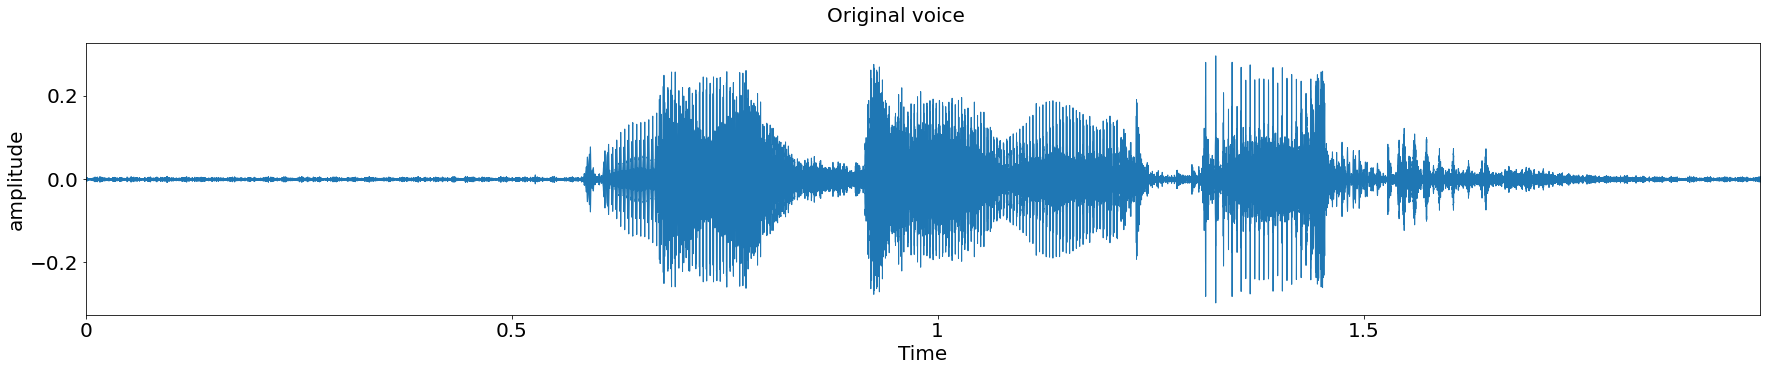

In [118]:
y, sr = librosa.load('./Downloads/COMP6321-ML-Project/Datasets/19-198-0000.wav')

#Plot the original voice
fig = plt.figure(figsize=(30, 5))
ax = plt.gca()
fig.suptitle('Original voice', fontsize=20)
plt.xlabel('', fontsize=20)
plt.ylabel('amplitude', fontsize=20)
ax.tick_params(axis = 'both', labelsize = 20)
librosa.display.waveplot(y, sr=sr)

#Play the voice
plt.show()
ipd.Audio(y, rate=22050)

# Plot the voice after noise reduction

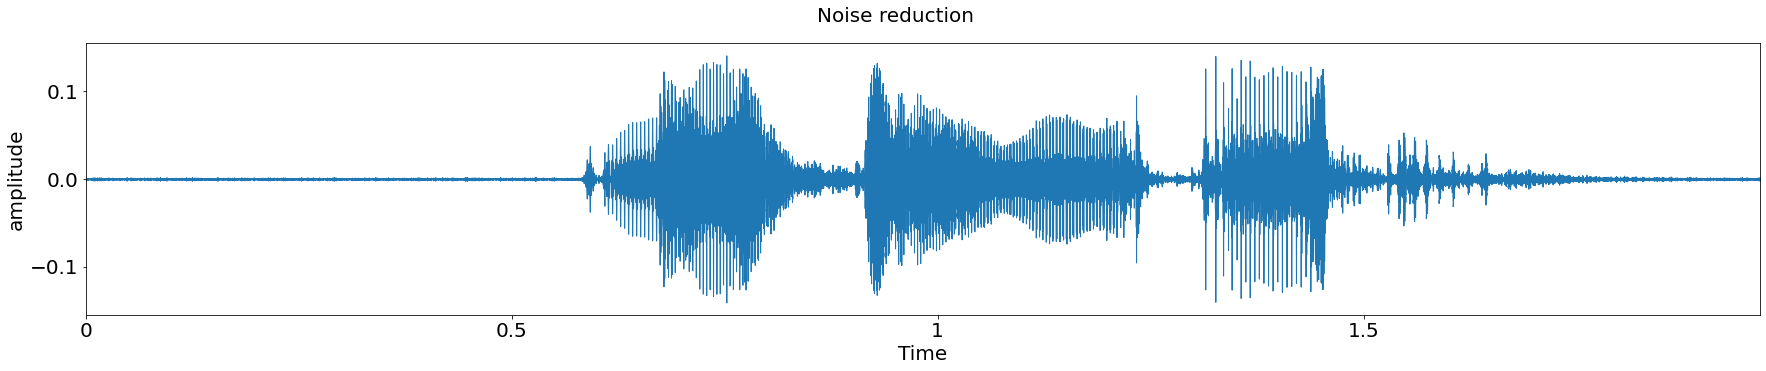

In [119]:
y_noise_reduced = ambient_noise_reduction(y, sr)

#Plot the noise reduction voice
fig = plt.figure(figsize=(30, 5))
ax = plt.gca()
fig.suptitle('Noise reduction', fontsize=20)
plt.xlabel('', fontsize=20)
plt.ylabel('amplitude', fontsize=20)
ax.tick_params(axis = 'both', labelsize = 20)
librosa.display.waveplot(y_noise_reduced, sr=sr)

#Play the voice
plt.show()
ipd.Audio(y_noise_reduced, rate=22050)

# Plot the voice after vocal enhancement

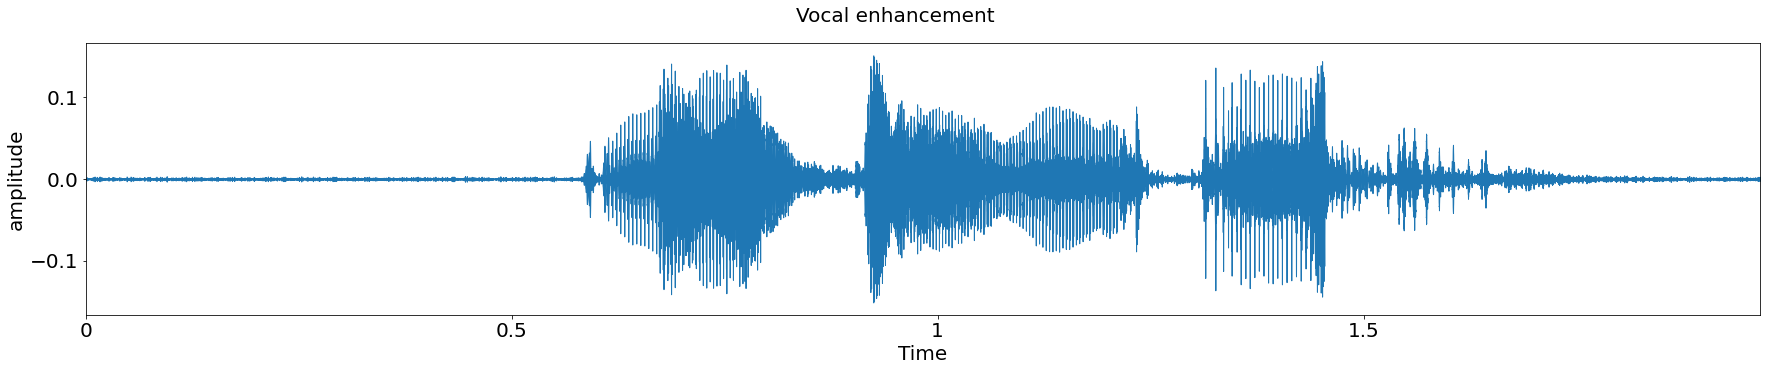

In [120]:
y_vocal_enhanced = vocal_enhancement(y_noise_reduced, sr)

#Plot the vocal enhanced voice
fig = plt.figure(figsize=(30, 5))
ax = plt.gca()
fig.suptitle('Vocal enhancement', fontsize=20)
plt.xlabel('', fontsize=20)
plt.ylabel('amplitude', fontsize=20)
ax.tick_params(axis = 'both', labelsize = 20)
librosa.display.waveplot(y_vocal_enhanced, sr=sr)

#Play the voice
plt.show()
ipd.Audio(y_vocal_enhanced, rate=22050)

# Plot the voice after audio trimming

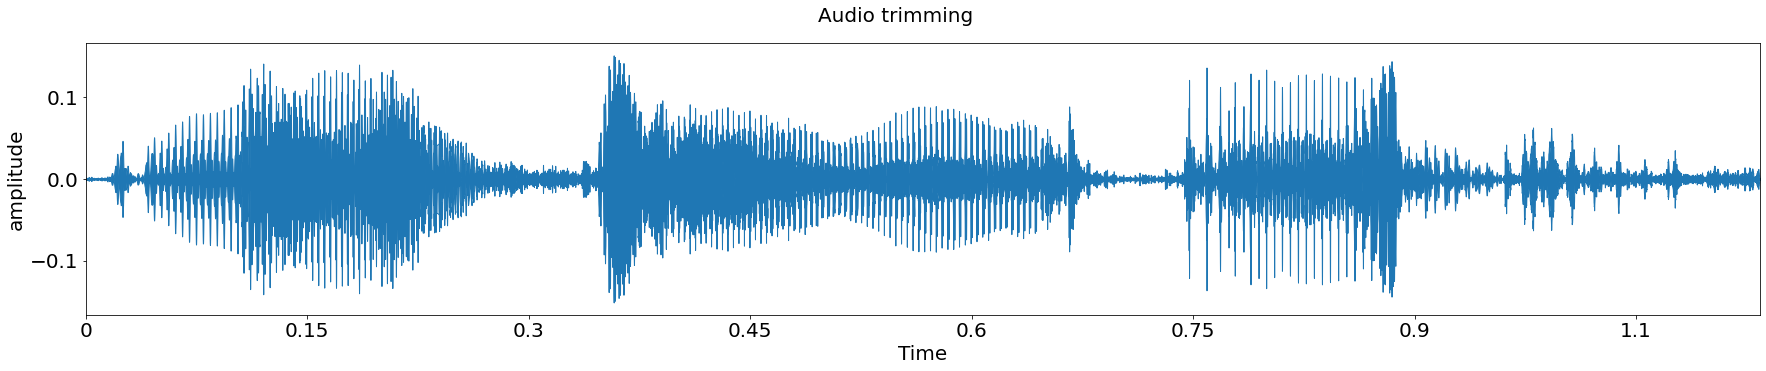

In [121]:
y_trimmed,_ = audio_trimming(y_vocal_enhanced, sr)
  
#Plot the audio trimmed voice
fig = plt.figure(figsize=(30, 5))
ax = plt.gca()
fig.suptitle('Audio trimming', fontsize=20)
plt.xlabel('', fontsize=20)
plt.ylabel('amplitude', fontsize=20)
ax.tick_params(axis = 'both', labelsize = 20)
librosa.display.waveplot(y_trimmed, sr=sr)

#Play the voice
plt.show()
ipd.Audio(y_trimmed, rate=22050)

# Extract the MFCC coefficients

In [123]:
#Play the the voice from MFCC coefficients
mfcc_features = librosa.feature.mfcc(y = y_trimmed, sr = sr, n_mfcc=13, hop_length=int(0.010 * sr), n_fft = int(0.025 * sr))
audio = librosa.feature.inverse.mfcc_to_audio(mfcc_features)
ipd.Audio(audio, rate=22050)

# Plot the normalized mfcc

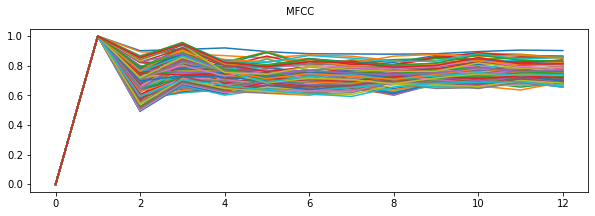

In [131]:
# Normalize the coefficients using standard scaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(mfcc_features)
mfcc_features_scaled = scaler.transform(mfcc_features)

#Plot the mfcc 
fig = plt.figure(figsize=(10, 3))
ax = plt.gca()
fig.suptitle('MFCC', fontsize=10)
plt.xlabel('', fontsize=20)
ax.tick_params(axis = 'both', labelsize = 10)
plt.plot(mfcc_features_scaled)
plt.show()


# Inverse the transform and mfcc

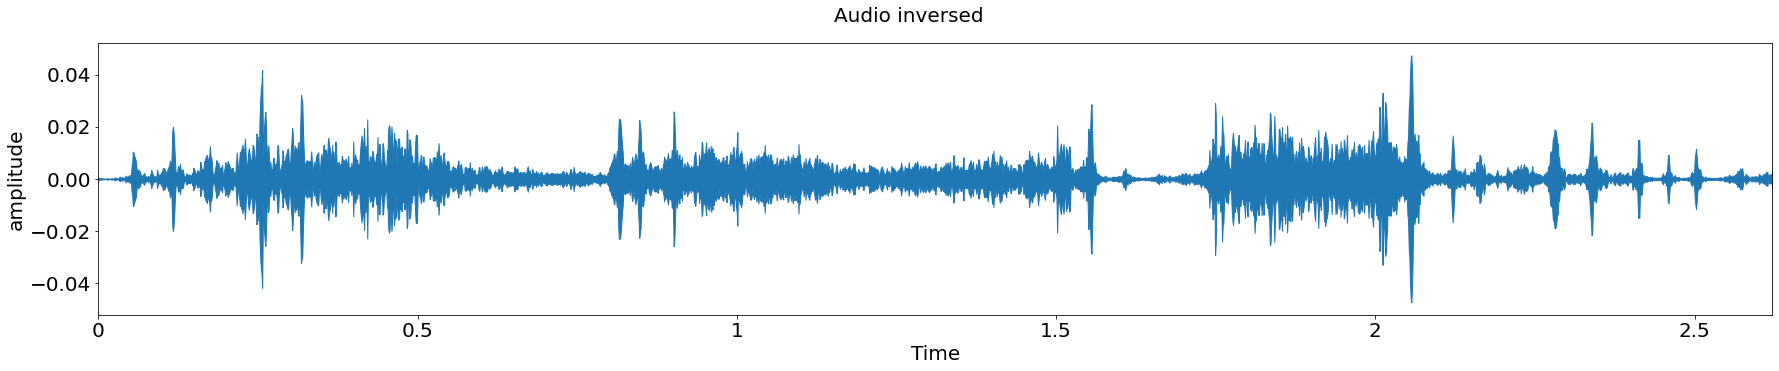

In [133]:
#inverse the transform and mfcc
inverse_voice = scaler.inverse_transform(mfcc_features_scaled)
audio = librosa.feature.inverse.mfcc_to_audio(inverse_voice)

#Plot the inversed voice
fig = plt.figure(figsize=(30, 5))
ax = plt.gca()
fig.suptitle('Audio inversed', fontsize=20)
plt.xlabel('', fontsize=20)
plt.ylabel('amplitude', fontsize=20)
ax.tick_params(axis = 'both', labelsize = 20)
librosa.display.waveplot(audio, sr=sr)

#Play the voice
plt.show()
ipd.Audio(audio, rate=22050)
